### Get started on this competition through Kaggle Scripts

This notebook is based on the Kaggle challenge [Bike Sharing Demand](https://www.kaggle.com/competitions/bike-sharing-demand/overview).

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city.

- Capital Bikeshare program in Washington D.C. collects detailed data
- The data set that will be used in the project is often used for research. A similar task was provided in a Kaggle challege.
- The goal of this project is to predict the bike sharing demand (variable `count`) in the future.

In [1]:
# import necessary libraries and set the style of the plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from IPython.core.display import HTML

# 1. Importing data

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/JalalMirzayev/kaggle-bike-task/main/data/data.csv", index_col="datetime", date_parser=pd.to_datetime)

In [3]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
datetime,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16.0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40.0
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32.0
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13.0
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1.0


You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

Data Fields
- datetime: hourly date + timestamp  
- season: 1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday: whether the day is considered a holiday
- workingday: whether the day is neither a weekend nor holiday
- weather: 
  - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp: temperature in Celsius
- atemp: "feels like" temperature in Celsius
- humidity: relative humidity
- windspeed: wind speed
- count: number of total rentals

# 2. Data exploration & Feature engineering

Print basic statistics for quantitative and categorical variables

In [4]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.028770,0.682721,1.425283,20.376474,23.788755,62.722884,12.736540,192.219000
std,1.106918,0.167165,0.465431,0.639357,7.894801,8.592511,19.292983,8.196795,178.272024
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,48.000000,7.001500,45.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,63.000000,12.998000,148.000000
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,285.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,50.000000,100.000000,56.996900,977.000000


The method `value_counts()` is a helpful for looking into categorical attributes, showing how often each unique value occurs. The code to check for unique weather categories is already prepared for you. 

Run the following code cell and think about the meaning of the output.

In [5]:
df["weather"].value_counts()

1    11413
2     4544
3     1419
4        3
Name: weather, dtype: int64

📝 **Task**: Determine `value_counts()` for two additional categorical attributes/columns/variables.

In [6]:
# Code for first categorical attribute
df["season"].value_counts()

3    4496
2    4409
1    4242
4    4232
Name: season, dtype: int64

In [7]:
# Code for second categorical attribute
df["holiday"].value_counts()

0    16879
1      500
Name: holiday, dtype: int64

📝 **Task:** Try to use `value_counts()` on a continuous column like `windspeed`. What do you notice? Does it make sense to determine value_counts() for continuous attributes?

In [8]:
df["windspeed"].value_counts()

0.0000     2180
8.9981     1738
11.0014    1695
12.9980    1657
7.0015     1617
15.0013    1513
6.0032     1425
16.9979    1295
19.0012    1048
19.9995     808
22.0028     602
23.9994     460
26.0027     381
27.9993     296
30.0026     176
31.0009     146
32.9975     112
35.0008      84
39.0007      44
36.9974      39
40.9973      23
43.0006      14
43.9989      11
46.0022       5
50.0021       2
54.0020       2
56.9969       2
47.9988       2
51.9987       1
55.9986       1
Name: windspeed, dtype: int64

## Creating insightful plots
Charts and diagrams are a very popular way to explore data and to understand relationships. There are multiple visualization packages for Python (e.g. Matplotlib, Seaborn, Plotly, etc.). These packages can be used to create different types of visualizations (e.g. scatter, bar, line, histogram, boxplot, etc.).

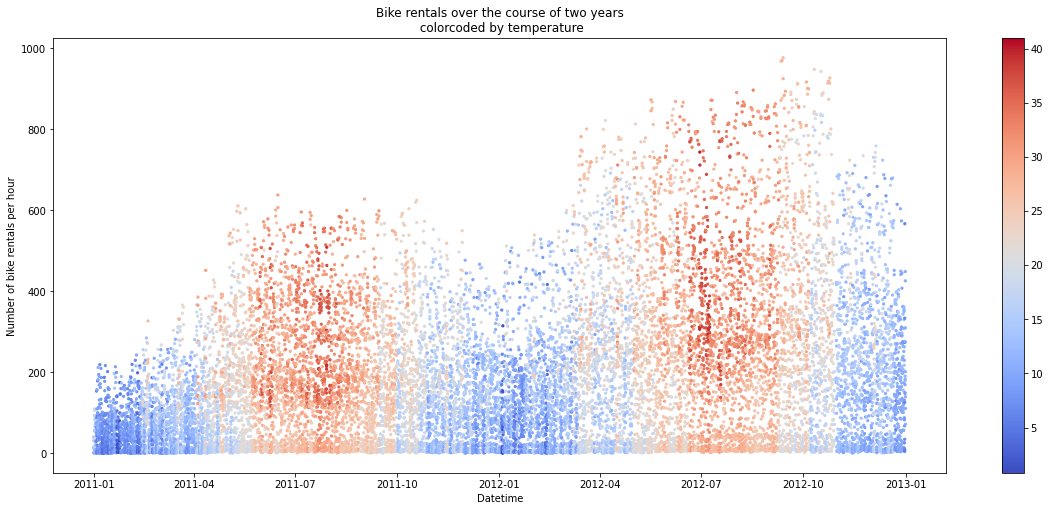

In [9]:
# plotting the output variable (count) over time gives us a first impression over the distribution
# plotting is usually done with matplotlib (imported as plt). We are defining the scatter plot in few steps:
plt.figure(figsize=(20, 8))
plt.scatter(df.index, df["count"], c=df["temp"], cmap="coolwarm", s=5)
plt.colorbar()
plt.xlabel("Datetime")
plt.ylabel("Number of bike rentals per hour")
plt.title("Bike rentals over the course of two years\n colorcoded by temperature")
display()

## Splitting timestamp into features (Feature engineering)

Feature engineering plays a crucial role for the performance of a machine learning algorithm. 

It encompasses various techniques such as 
- handling/removing outliers or missing values
- transformation of variables 
- scaling of variables
- combination of variables or 
- splitting a feature into several ones (e.g. date -> year, month, day)

In [10]:
# the datetime timestamp provides valuable information, we need to extract the individual attributes in order to make better use of it
df["hour"] = [datetime.hour for datetime in df.index]
# 📝 Task: Use the same procedure for day, month, and year.
df["day"] = [datetime.day for datetime in df.index]
df["month"] = [datetime.month for datetime in df.index]
df["year"] = [datetime.year for datetime in df.index]

df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month,year
datetime,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16.0,0,1,1,2011
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40.0,1,1,1,2011
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32.0,2,1,1,2011
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13.0,3,1,1,2011
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1.0,4,1,1,2011


We splitted the date into components and there is already other information extracted out of a date (season, holiday, workingday) 

📝 **Task**: Can you think of another potentially valuable attribute that we could try to extract?

In [11]:
df["day_of_the_week"] = [datetime.dayofweek for datetime in df.index]

df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month,year,day_of_the_week
datetime,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16.0,0,1,1,2011,5
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40.0,1,1,1,2011,5
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32.0,2,1,1,2011,5
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13.0,3,1,1,2011,5
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1.0,4,1,1,2011,5


## Train - Test split for model training and evaluation

In supervised learning, we always have a labeled training set (=the correct output) at hand. The evaluation of the model is done with previously unseen data. Therefore, we need to split our dataframe representing the full data set beforehand.

In [12]:
# There are mutltiple ways to create a train - test split. Using the Pandas-internal sample() function is straightforward.
df_train = df.sample(frac=0.75, random_state=1)
df_test = df.drop(df_train.index)

In [13]:
# We need to break down the train - test sets into independent variables (input features: what we have as input) and dependent variable (target: what we want to predict)
x_train = df_train.drop(["count"], axis=1)
y_train = df_train["count"]

x_test = df_test.drop(["count"], axis=1)
y_test = df_test["count"]

## 3. Supervised Machine Learning with Decision Trees

### Training a decision tree model
Decision Trees based algorithms are very popular in machine learning. They are easy to set-up, capable of capturing non-linearity, good at handling categorical variables and intuitive to understand. Trees are built from the top to the ground, branches and their associated splitting criteria are always created in order to improve a given metric. Being greedy algorithms, they always search for the local optimum at every split.

In [14]:
# the object of the model with selected parameters has to be created. max_depth specifies how many layers we want in the tree, criterion defines the splitting metric
model1 = DecisionTreeRegressor(criterion='absolute_error', max_depth=3)

# now the model becomes trained with fit() using the previously created training data
model1.fit(x_train, y_train)

DecisionTreeRegressor(criterion='absolute_error', max_depth=3)

### Predicting results and visualizing the decision tree


In [15]:
# the trained model is now ready to predict any new input having the same attributes as the training data
y_predictions1 = model1.predict(x_test)

# the output is simply a list of the forecasted bike rentals in the test set
print("y_predictions: ", y_predictions1[:5])

# print input features
df_test.head()

y_predictions:  [ 44.  99. 304.  99.  99.]


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day,month,year,day_of_the_week
datetime,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16.0,0,1,1,2011,5
2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,14.0,9,1,1,2011,5
2011-01-01 14:00:00,1,0,0,2,18.86,22.725,72,19.0012,106.0,14,1,1,2011,5
2011-01-01 15:00:00,1,0,0,2,18.04,21.970,77,19.9995,110.0,15,1,1,2011,5
2011-01-01 18:00:00,1,0,0,3,17.22,21.210,88,16.9979,35.0,18,1,1,2011,5


In [16]:
HTML('<img src="https://raw.githubusercontent.com/JalalMirzayev/kaggle-bike-task/main/images/decision_tree_plot.png" style="width:800px;height:400px;">')

In [17]:
# Let us look at an individual case and follow the path of our decision tree
print('Prediction: ' + str(y_predictions1[2]))
print(df_test.iloc[2])

Prediction: 304.0
season                1.0000
holiday               0.0000
workingday            0.0000
weather               2.0000
temp                 18.8600
atemp                22.7250
humidity             72.0000
windspeed            19.0012
count               106.0000
hour                 14.0000
day                   1.0000
month                 1.0000
year               2011.0000
day_of_the_week       5.0000
Name: 2011-01-01 14:00:00, dtype: float64


### Evaluating model performance
Many different evaluation metrics can be used to assess a model's performance.
The following three metrics are often used to evaluate the performance of regression models

<hr style="border:2px solid gray"> </hr>

**Mean Squared Error**. The Mean Squared Error (MSE) is defined as follows

$$ \text{MSE} = \frac{1}{N}\sum_{n=1}^N[y_\text{n, actual} - y_\text{n,predict}]^2,$$

in which $y_\text{n,predict}$ is the prediction for the $n^\text{th}$ observation. The value $y_\text{n, actual}$ is the actual value of the $n^\text{th}$ observation.

<hr style="border:2px solid gray"> </hr>

**Mean Absolute Error**. The Mean Absolute Error (MAE) is defined as follows

$$ \text{MSE} = \frac{1}{N}\sum_{n=1}^N\left|y_\text{n, actual} - y_\text{n,predict}\right|^2,$$

in which $y_\text{n,predict}$ is the prediction for the $n^\text{th}$ observation. The value $y_\text{n, actual}$ is the actual value of the $n^\text{th}$ observation.

<hr style="border:2px solid gray"> </hr>

**Coefficient of determination**. The coefficient of determination (also known as $R^2$ or $R$ squared, ger. Bestimmtheitsmaß/Determinationskoeffizient) is defined as follows

$$R^2 = \dfrac{\sum_{n=1}^N[y_\text{n,predict}-\overline{y}]^2}{\sum_{n=1}^N[y_\text{n,actual}-\overline{y}]^2 },$$

in which $y_\text{n,predict}$ is the prediction for the $n^\text{th}$ observation. The value $y_\text{n, actual}$ is the actual value of the $n^\text{th}$ observation. Finally, $\overline{y}$ is the mean of all actual obervations $y_\text{n, actual}$. 

In [18]:
print("mean squared error: ", mean_squared_error(y_test, y_predictions1))
print("mean absolute error: ", mean_absolute_error(y_test, y_predictions1))
print("R²: ", r2_score(y_test, y_predictions1))

mean squared error:  15984.006904487916
mean absolute error:  83.00621403912542
R²:  0.47909772778067283


## Hyperparameter tuning
The Decision Tree has several parameters which can be tuned. It's an important part of machine learning to set appropriate values for these parameters.

In [19]:
# below you can see the same code as before. Set different values for criterion(mse|friedman_mse) and max_depth(positive integer)
model2 = DecisionTreeRegressor(criterion="absolute_error", max_depth=100)
model2.fit(x_train, y_train)
y_predictions2 = model2.predict(x_test)

# [optional] you can try out even more parameters as described in https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [20]:
print("mean squared error: ", mean_squared_error(y_test, y_predictions2))
print("mean absolute error: ", mean_absolute_error(y_test, y_predictions2))
print("R²: ", r2_score(y_test, y_predictions2))

mean squared error:  2090.998619102417
mean absolute error:  26.542922899884925
R²:  0.931856515177549


## Feature Importance: What features are important for prediction?

An interesting byproduct of building a decision tree is the Feature Importance. The importance of a feature is computed as the (normalized) total reduction of the criterion (e.g. MAE) brought by that feature. It is a crcuial measure for interpreting the model.

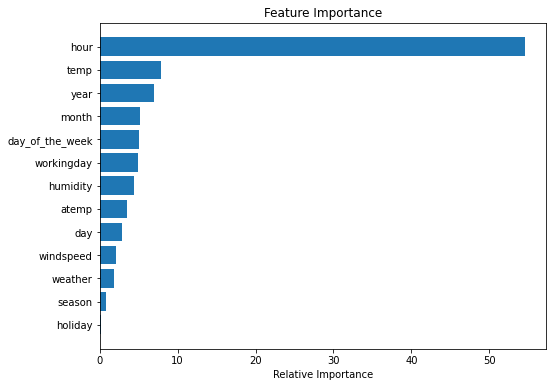

In [21]:
# we get the feature importance out of the model, calculate relative values and print them as bar chart
feature_importance = model2.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.sum())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(8,6))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, x_train.columns[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Feature Importance")
display()

### Improving performance with decision tree ensemble methods
Despite being a powerful concept, also decision trees have their drawbacks. They tend to overfit on the training data, leading to suboptimal generalization capabilities. Generally, they don't yield a high prediction accuracy in many situations. Decision tree ensemble methods tackle these issues by building on the concept of randomization. Random Forest includes many trees in a single model (=forest) but only consides subsets of training data and input features for building the individual tree. In practice, this method achieves significantly higher robustness and performance compared to a singular decision tree. It is a popular choice for a wide range of real-world data science use cases.

In [22]:
# we need to create an object of the RandomForestRegressor() class. n_estimators defines the amount of trees in the forest, n_jobs at -1 activates mulitcore processing
model3 = RandomForestRegressor(n_estimators=100, n_jobs=-1)
model3.fit(x_train, y_train)
y_predictions3 = model3.predict(x_test)

In [23]:
print("mean squared error: ", mean_squared_error(y_test, y_predictions3))
print("mean absolute error: ", mean_absolute_error(y_test, y_predictions3))
print("R²: ", r2_score(y_test, y_predictions3))

mean squared error:  1067.0851930264673
mean absolute error:  18.335532796317608
R²:  0.9652247959463145
